Found 3000 images belonging to 3 classes.
Training with input vector of shape: (49152,)
No match found, creating a new category
Training with input vector of shape: (49152,)
No match found, creating a new category
Training with input vector of shape: (49152,)
No match found, creating a new category
Training with input vector of shape: (49152,)
No match found, creating a new category
Training with input vector of shape: (49152,)
No match found, creating a new category
Training with input vector of shape: (49152,)
No match found, creating a new category
Training with input vector of shape: (49152,)
No match found, creating a new category
Training with input vector of shape: (49152,)
No match found, creating a new category
Training with input vector of shape: (49152,)
No match found, creating a new category
Training with input vector of shape: (49152,)
No match found, creating a new category
Training with input vector of shape: (49152,)
No match found, creating a new category
Training wit

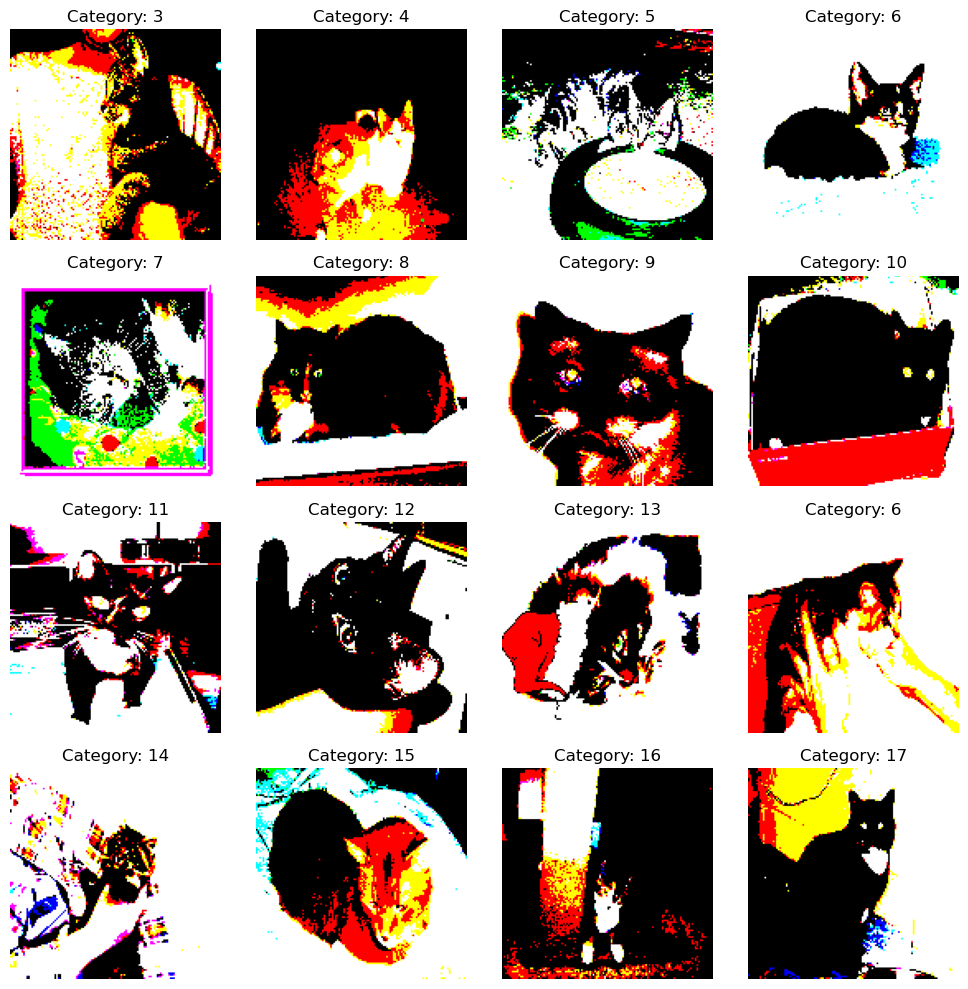

In [13]:
# Step 1: Set up the environment
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from sklearn.preprocessing import binarize

# Set up the path to the dataset
data_dir = 'animal-image-classification/Animals'

# Step 2: Load and preprocess the dataset
img_width, img_height = 128, 128  # Resizing images for uniformity
channels = 3  # Number of channels: 3 for RGB, 1 for grayscale
batch_size = 32

# Data Generator to load and preprocess images
datagen = ImageDataGenerator(rescale=1.0/255.0)
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

# Convert images to binary format
def to_binary(images, threshold=0.5):
    return binarize(images.reshape(-1, img_width * img_height * channels), threshold=threshold).reshape(images.shape)

binary_images = to_binary(next(train_generator))

# Step 3: Implement ART-1 Neural Network
class ART1Network:
    def __init__(self, input_size, num_categories, vigilance=0.8):
        self.input_size = input_size
        self.num_categories = num_categories
        self.vigilance = vigilance
        self.weights = np.random.rand(num_categories, input_size)
        
    def _match(self, input_vector):
        matches = []
        for i, weight_vector in enumerate(self.weights):
            # Debugging statement to check shapes
            similarity = np.dot(input_vector, weight_vector) / (np.linalg.norm(input_vector) * np.linalg.norm(weight_vector))
            if similarity >= self.vigilance:
                matches.append(i)
        return matches

    def train(self, inputs):
        for input_vector in inputs:
            # Flatten the input vector if needed to match the weight vector shape
            input_vector = input_vector.flatten()
            print(f"Training with input vector of shape: {input_vector.shape}")
            matches = self._match(input_vector)
            if matches:
                # Update weights for the best match
                chosen_index = matches[0]
                print(f"Updating weights for category {chosen_index}")
                self.weights[chosen_index] = self.weights[chosen_index] * input_vector
            else:
                # No match found, create a new category
                print(f"No match found, creating a new category")
                self.weights = np.vstack([self.weights, input_vector])
                self.num_categories += 1

    def predict(self, input_vector):
        input_vector = input_vector.flatten()  # Ensure input vector is flattened
        matches = self._match(input_vector)
        return matches[0] if matches else -1

# Initialize ART1 network
input_size = img_width * img_height * channels  # Updated to match the actual image size
num_categories = 3  # Initial number of categories
art1 = ART1Network(input_size, num_categories)

# Step 4: Train the network
art1.train(binary_images)

# Step 5: Evaluate the network
predictions = [art1.predict(img) for img in binary_images]

# Step 6: Visualize results
import matplotlib.pyplot as plt

# Display some categorized images with their categories
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.imshow(binary_images[i].reshape(img_width, img_height, channels), cmap='gray')
    ax.set_title(f'Category: {predictions[i]}')
    ax.axis('off')

plt.tight_layout()
plt.savefig("art1-sample-categories")

In [7]:
# New Cell: Categorize a Single Image

from tensorflow.keras.preprocessing import image

def categorize_image(img_path, model):
    # Load the image
    img = image.load_img(img_path, target_size=(img_width, img_height))
    
    # Convert to array and rescale
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Rescale to [0, 1] range
    
    # Convert the image to binary format
    binary_img = to_binary(np.expand_dims(img_array, axis=0))
    
    # Flatten the binary image for prediction
    flattened_img = binary_img.flatten()
    
    # Predict the category using the ART-1 model
    category = model.predict(flattened_img)
    
    return category

# Example usage
image_path = 'cat-yellow-face-sitting-on-600nw-2470054451.webp'  # Replace with the path to the image you want to categorize
predicted_category = categorize_image(image_path, art1)
print(f'The predicted category for the image is: {predicted_category}')

Matching input shape: (49152,) with weight vector shape: (49152,)
Matching input shape: (49152,) with weight vector shape: (49152,)
Matching input shape: (49152,) with weight vector shape: (49152,)
Matching input shape: (49152,) with weight vector shape: (49152,)
Matching input shape: (49152,) with weight vector shape: (49152,)
Matching input shape: (49152,) with weight vector shape: (49152,)
Matching input shape: (49152,) with weight vector shape: (49152,)
Matching input shape: (49152,) with weight vector shape: (49152,)
Matching input shape: (49152,) with weight vector shape: (49152,)
Matching input shape: (49152,) with weight vector shape: (49152,)
Matching input shape: (49152,) with weight vector shape: (49152,)
Matching input shape: (49152,) with weight vector shape: (49152,)
Matching input shape: (49152,) with weight vector shape: (49152,)
Matching input shape: (49152,) with weight vector shape: (49152,)
Matching input shape: (49152,) with weight vector shape: (49152,)
Matching i

In [8]:
# Function to categorize an image and display other images in the same category
def categorize_and_display_similar_images(model, images, num_images=5):
    # Prompt user for input
    img_path = input("Enter the path to the image: ")
    
    # Load and preprocess the image
    original_img = load_and_preprocess_image(img_path)
    binary_img = convert_to_binary_image(original_img)
    
    # Flatten the binary image for prediction
    flattened_img = binary_img.flatten()
    
    # Predict the category using the ART-1 model
    predicted_category = model.predict(flattened_img)
    
    # Find other images in the same category
    indices = find_images_in_category(predicted_category, images, model)
    
    # Ensure we don't display more images than are available
    num_images = min(num_images, len(indices))
    
    # Display the original image along with other images in the same category
    fig, axs = plt.subplots(1, num_images + 1, figsize=(15, 15))
    
    # Display the original image in the first subplot
    axs[0].imshow(original_img, cmap='gray' if channels == 1 else None)
    axs[0].set_title(f'Original Image - Category {predicted_category}')
    axs[0].axis('off')
    
    # Display other images from the same category
    for i in range(num_images):
        ax = axs[i + 1]
        img = images[indices[i]].reshape(img_width, img_height, channels)
        ax.imshow(img, cmap='gray' if channels == 1 else None)
        ax.set_title(f'Category {predicted_category}')
        ax.axis('off')
    
    plt.savefig("art1-image-detection")

# Example usage
categorize_and_display_similar_images(art1, binary_images)

Enter the path to the image:  cat-yellow-face-sitting-on-600nw-2470054451.webp


NameError: name 'load_and_preprocess_image' is not defined

In [106]:
!kaggle datasets download borhanitrash/animal-image-classification-dataset

Dataset URL: https://www.kaggle.com/datasets/borhanitrash/animal-image-classification-dataset
License(s): MIT
 91%|██████████████████████████████████▋   | 35.0M/38.4M [00:02<00:00, 20.7MB/s]
100%|██████████████████████████████████████| 38.4M/38.4M [00:02<00:00, 17.0MB/s]


In [11]:
import os
from PIL import Image

def load_images(image_dir, image_size=(32, 32)):
    images = []
    labels = []
    for label in os.listdir(image_dir):
        label_dir = os.path.join(image_dir, label)
        if os.path.isdir(label_dir):
            for image_file in os.listdir(label_dir):
                image_path = os.path.join(label_dir, image_file)
                image = Image.open(image_path).convert('L').resize(image_size)
                image_array = np.array(image).flatten()
                # Binarize image: convert to 1 (white) or -1 (black)
                image_array = np.where(image_array > 128, 1, -1)
                images.append(image_array)
                labels.append(label)
    return np.array(images), np.array(labels)

image_dir = 'animal-image-classification/Animals'
images, labels = load_images(image_dir)

In [15]:
import numpy as np
import time
from sklearn.model_selection import train_test_split
from collections import Counter

# Klasa ART1Network została już zdefiniowana wcześniej

def analyze_art1_network(images, labels, vigilance=0.9):
    input_size = images.shape[1]
    num_categories = len(np.unique(labels))
    
    # Tworzymy sieć ART1
    art_net = ART1Network(input_size, num_categories, vigilance=vigilance)
    
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
    
    # Trenujemy sieć ART1 na danych treningowych
    art_net.train(X_train)
    
    # 1. Wpływ liczby neuronów (kategori)
    num_neurons = len(art_net.weights)
    print(f"Liczba kategorii po treningu: {num_neurons}")
    
    # 2. Pojemność sieci
    print(f"Pojemność sieci (liczba kategorii): {num_neurons}")
    
    # 3. Czas konwergencji
    convergence_times = []
    for pattern in X_test:
        start_time = time.time()
        prediction = art_net.predict(pattern)
        end_time = time.time()
        convergence_times.append(end_time - start_time)
    
    avg_convergence_time = np.mean(convergence_times)
    print(f"Średni czas konwergencji: {avg_convergence_time:.4f} sekund")
    
    # 4. Dokładność rozpoznawania wzorców
    correct = 0
    for i, pattern in enumerate(X_test):
        prediction = art_net.predict(pattern)
        if prediction == y_test[i]:
            correct += 1
    accuracy = correct / len(X_test)
    print(f"Dokładność rozpoznawania wzorców: {accuracy * 100:.2f}%")

# Wywołanie analizy dla obrazów (X) i etykiet (y)
analyze_art1_network(images, labels)

Training with input vector of shape: (1024,)
No match found, creating a new category
Training with input vector of shape: (1024,)
No match found, creating a new category
Training with input vector of shape: (1024,)
No match found, creating a new category
Training with input vector of shape: (1024,)
No match found, creating a new category
Training with input vector of shape: (1024,)
No match found, creating a new category
Training with input vector of shape: (1024,)
No match found, creating a new category
Training with input vector of shape: (1024,)
No match found, creating a new category
Training with input vector of shape: (1024,)
No match found, creating a new category
Training with input vector of shape: (1024,)
No match found, creating a new category
Training with input vector of shape: (1024,)
No match found, creating a new category
Training with input vector of shape: (1024,)
No match found, creating a new category
Training with input vector of shape: (1024,)
No match found, crea